# Distillation des connaissances pour la détection d'anomalies non supervisée

Dans ce notebook d'application, nous allons mettre en pratique la distillation des connaissances dans le cas particulier de la détection d'anomalies non supervisée. 

Pour cela, nous allons nous inspirer du papier [Student-Teacher Feature Pyramid Matching for Anomaly Detection](https://arxiv.org/pdf/2103.04257) et du [code correspondant](https://github.com/xiahaifeng1995/STPM-Anomaly-Detection-Localization-master).   
Voici la figure, extraite de l'article, décrivant le fonctionnement de la méthode : 

<img src="images/stpm.png" alt="stpm" width="700"/>


## Choix du backbone student/teacher et dataset

### Backbone et loss

L'article utilise [resnet18](https://arxiv.org/pdf/1512.03385) comme architecture de réseau avec le modèle teacher pré-entrainé sur [ImageNet](https://www.image-net.org/). Le student utilise la même architecture mais le réseau est initialisé aléatoirement. 

Comme décrit dans la figure ci-dessus le loss est calculé sur les sorties des 3 premiers groupes de couches de resnet18 (un groupe de couche correspond à l'ensemble des couches qui opérent à la même résolution d'image). C'est à dire que le réseau student est entraîné à reproduire les feature map du réseau teacher sur ces 3 sorties uniquement. Le score d'anomalie sera aussi calculé sur ces sorties uniquement.  

Pour ce qui est de la fonction de loss, il s'agit simplement du loss MSE qui nous avons vu précedemment. Ce loss est calculé sur chaque feature map puis sommé pour obtenir le loss total. 

### Dataset

Le dataset utilisé dans l'article est le dataset [MVTEC AD](https://www.mvtec.com/company/research/datasets/mvtec-ad) qui regroupe 15 catégories dont 10 objets et 5 textures. Il y a environ 350 images sans défauts pour l'entraînement et une centaine d'images défectueuses pour le test (par catégorie bien sûr).  
Voici un aperçu des images du dataset : 

<img src="images/mvtec.png" alt="mvtec" width="700"/>

Vous pouvez télécharger le dataset [ici](https://www.mvtec.com/company/research/datasets/mvtec-ad). Pour notre implémentation, nous utiliserons la catégorie hazelnut (noisette).


## Implémentation pytorch et timm

Certaines fonctions sont un peu compliquée et pas nécessaire à comprendre pour appréhender le concept (chargement du dataset etc ...). Pour plus de clarté, ces fonctions et classes ont été déplacées dans le fichier utils.py que vous pouvez consulter si besoin. 

In [1]:
import matplotlib.pyplot as plt
from utils import MVTecDataset,cal_anomaly_maps
import torch
import torch.nn as nn
import timm
import torch.nn.functional as F
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset

On va commencer par charger notre dataset et regarder rapidement ce qu'il contient.  
Cette fois, on va vraiment séparer notre training en train et validation pour pouvoir évaluer le modèle pendant l'entraînement.

In [2]:
train_dataset = MVTecDataset(root_dir="../data/mvtec/hazelnut/train/good",resize_shape=[256,256],phase='train')
test_dataset = MVTecDataset(root_dir="../data/mvtec/hazelnut/test/",resize_shape=[256,256],phase='test')
print("taille du dataset d'entrainement : ",len(train_dataset))
print("taille du dataset de test : ",len(test_dataset))
print("taille d'une image : ",train_dataset[0]['imageBase'].shape)

# Séparation du dataset d'entrainement en train et validation
img_nums = len(train_dataset)
valid_num = int(img_nums * 0.2)
train_num = img_nums - valid_num
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

# Création des dataloaders
train_loader=torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
val_loader=torch.utils.data.DataLoader(val_data, batch_size=4, shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


taille du dataset d'entrainement :  391
taille du dataset de test :  110
taille d'une image :  (3, 256, 256)


On peut visualiser quelques défauts : 

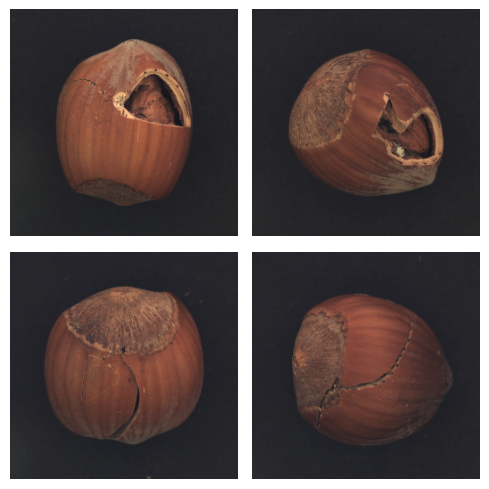

In [3]:
num_defects_displayed = 0
fig, axes = plt.subplots(2, 2, figsize=(5, 5))

for sample in test_loader:
  image = sample['imageBase']
  has_defect = sample['has_anomaly']
  if has_defect:
    row = num_defects_displayed // 2
    col = num_defects_displayed % 2
    
    axes[row, col].imshow(image.squeeze().permute(1, 2, 0).numpy())
    axes[row, col].axis('off')  
    
    num_defects_displayed += 1
    
    if num_defects_displayed == 4:
      break
plt.tight_layout()
plt.show()

### Création de nos deux modèles teacher et student

Pour nos modèles, nous allons utiliser la même classe et mettre en paramètre les spécificités de chaque modèle.   
Pour faciliter l'utilisation d'un backbone déjà existant, nous utilisons la library [timm](https://timm.fast.ai/) (pytorch image models). C'est une library très intéressante pour accéder à des backbones et des modèles déjà entraîné. Il y a également une certain flexibilité sur la manipulation du réseau.

In [4]:
class resnet18timm(nn.Module):
    def __init__(self,backbone_name="resnet18",out_indices=[1,2,3],pretrained=True):
        super(resnet18timm, self).__init__()     
        # Features only permet permet de ne récupérer que les features et pas la sortie du réseau, out_indices permet de choisir les couches à récupérer
        self.feature_extractor = timm.create_model(backbone_name,pretrained=pretrained,features_only=True,out_indices=out_indices)
        if pretrained:
            # Si le modèle est pré-entrainé (donc c'est le teacher), on gèle les poids
            self.feature_extractor.eval() 
            for param in self.feature_extractor.parameters():
                param.requires_grad = False   
        
    def forward(self, x):
        features = self.feature_extractor(x)
        return features

On peut maintenant créer notre teacher et notre student : 

In [5]:
student=resnet18timm(backbone_name="resnet18",out_indices=[1,2,3],pretrained=False).to(device)
teacher=resnet18timm(backbone_name="resnet18",out_indices=[1,2,3],pretrained=True).to(device)

### Fonction de loss

La fonction de loss utilse la distance euclidienne (MSE) définie comme ceci :  
$D(I_1, I_2) = \sqrt{\sum_{i=1}^{m} \sum_{j=1}^{n} \left( I_1(i,j) - I_2(i,j) \right)^2}$ où $I_1$ et $I_2$ sont nos deux images.   

Notre implémentation du loss va donc utiliser cette distance pour comparer les feature map entre elles pour les 3 paires de feature map : 

In [6]:
class loss_kdad:
  def __init__(self):
    pass
  # fs_list : liste des features du student et ft_list : liste des features du teacher
  def __call__(self,fs_list, ft_list):
    t_loss = 0
    N = len(fs_list)
    for i in range(N):
      fs = fs_list[i]
      ft = ft_list[i]
      _, _, h, w = fs.shape
      # Normaliser les features améliore les résultats
      fs_norm = F.normalize(fs, p=2)
      ft_norm = F.normalize(ft, p=2)

      # Calcul de la distance euclidienne
      f_loss = 0.5 * (ft_norm - fs_norm) ** 2
      # On prend la moyenne de la loss sur tous les pixels
      f_loss = f_loss.sum() / (h * w)
      t_loss += f_loss

    return t_loss / N

### Entraînement du modèle

Définissons nos hyperparamètres : 

In [7]:
epochs= 20
lr=0.0004
criterion = loss_kdad()
optimizer = torch.optim.Adam(student.parameters(), lr=lr)

Il est temps d'entraîner le modèle ! L'entrainement peut prendre un certain temps.

In [8]:
for epoch in range(epochs):
    student.train()
    train_loss = 0.0
    for data in train_loader:
        image = data['imageBase'].to(device)
        optimizer.zero_grad()
        outputs_student = student(image)
        outputs_teacher = teacher(image)
        loss = criterion(outputs_student,outputs_teacher)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    student.eval()
    val_loss = 0.0
    for data in val_loader:
        image = data['imageBase'].to(device)
        outputs_student = student(image)
        outputs_teacher = teacher(image)
        loss = criterion(outputs_student,outputs_teacher)
        val_loss += loss.item()
    print("Epoch {} - train loss : {} - val loss : {}".format(epoch,train_loss/len(train_loader),val_loss/len(val_loader)))

Epoch 0 - train loss : 1.6731480107277255 - val loss : 1.3833315640687942


On peut maintenant évaluer notre modèle. Pour cela, nous utilisons la mesure AUROC (voir cours 9 pour un rappel).

In [ ]:
scores = []
test_imgs = []
gt_list = []
for sample in test_loader:
    label=sample['has_anomaly']
    image = sample['imageBase'].to(device)
    test_imgs.extend(image.cpu())
    gt_list.extend(label.cpu().numpy())
    with torch.set_grad_enabled(False):
        
        outputs_student = student(image)
        outputs_teacher = teacher(image) 

        # La fonction cal_anomaly_maps permet de calculer la carte d'anomalie (ça sera utile pour la visualisation après)
        score =cal_anomaly_maps(outputs_student,outputs_teacher,256) 
        
    scores.append(score)
scores = np.asarray(scores)
gt_list = np.asarray(gt_list)

from sklearn.metrics import roc_auc_score

map_scores = np.asarray(scores)

max_anomaly_score = map_scores.max()
min_anomaly_score = map_scores.min()
map_scores = (map_scores - min_anomaly_score) / (max_anomaly_score - min_anomaly_score)
img_scores = map_scores.reshape(map_scores.shape[0], -1).max(axis=1)
gt_list = np.asarray(gt_list)
img_roc_auc = roc_auc_score(gt_list, img_scores)
print(" image hazelnut ROCAUC : %.3f" % (img_roc_auc))


 image hazelnut ROCAUC : 1.000


On obtient un très bon AUROC, notre modèle est très bon pour détecter les défauts sur les noisettes. 

### Visualisation de la carte d'anomalies

Pour calculer le score, nous avons comparé les feature map du teacher à celle du student sur les 3 sorties (de dimension différente). A l'aide de la fonction cal_anomaly_maps, nous avons effectué les comparaisons et reconstruit une carte d'anomalie de la taille de l'image de base. On peut visualiser cette carte d'anomalie pour obtenir une localisation du défaut. 

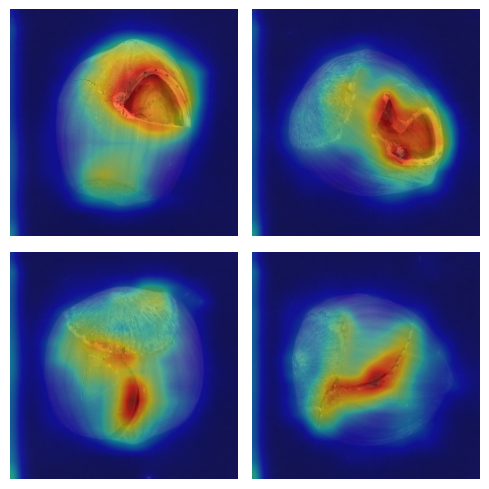

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5))

for i,(img,mask) in enumerate(zip(test_imgs,scores)):
    img_act=img.squeeze().permute(1, 2, 0).numpy()
    row = i // 2
    col = i % 2
    axs[row, col].imshow(img_act) 
    axs[row, col].imshow(mask, cmap='jet', alpha=0.5)
    axs[row, col].axis('off')
    if i==3:
        break
    
plt.tight_layout()
plt.show()


On constate que la localisation est assez précise bien que ça ne soit pas le but premier de notre modèle.